<a href="https://colab.research.google.com/github/PKpacheco/pre_process_dados_puc/blob/main/aula_2_pre_process_dados_titulo_reportagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install spacy pyLDAvis

     |████████████████████████████████| 1.7MB 5.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.9MB 19.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136897 sha256=bbbc94d355372e63ab9eb5ca633406ee69c4194bb83ba7c2fb5d90e64725962e
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: pyldavis 3.3.1 has requirement numpy>=1.20.0, but you'll have numpy 1.19.5 which is incompatible.
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


In [4]:
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 21.2MB 1.2MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-cp37-none-any.whl size=21186282 sha256=158856fc338290a336c4a9d382663339d23feffcd6b00cf8070d21cbd98f05b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-nswdqowf/wheels/ea/94/74/ec9be8418e9231b471be5dc7e1b45dd670019a376a6b5bc1c0
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk import word_tokenize
from nltk.util import ngrams
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# conjunto de dados
news = pd.read_csv('https://www.dropbox.com/s/rvwjw8miow6jswy/articles.csv?dl=1')

In [4]:
news.head()

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


In [5]:
# filtro por turismo
turismo = news[news['category']== 'turismo']
turismo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1903 entries, 381 to 167031
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        1903 non-null   object
 1   text         1903 non-null   object
 2   date         1903 non-null   object
 3   category     1903 non-null   object
 4   subcategory  0 non-null      object
 5   link         1903 non-null   object
dtypes: object(6)
memory usage: 104.1+ KB


In [37]:
def limpa_texto(texto):

  c = re.sub(r'\n', ' ', texto) # toda vez que encontrar um \n substituir por espaco
  c = re.sub(r'\r', ' ', c) # toda vez que encontrar um \r substituir por espaco

  c = c.replace(':', '')
  c = c.replace('/', '')
  c = re.sub(r'R\$', '', c) # subst simbolo de moeda cifrão por nada
  c = re.sub(r'\W', ' ', c)  # caracteres alfa numericos substituir por vazio 
  c = re.sub(r'\s+',' ', c) # substituir multiplos espaços por 1 só
  c = re.sub(r'^\s+','', c) # subst espaços no inicio da frase por nada
  c = re.sub(r'\s+$','', c) # subst espaços no final da frase por nada

  return c.lower() # texto todo em minuscula

In [8]:
from spacy.lang.pt import Portuguese

In [10]:
STOP_WORDS = spacy.lang.pt.STOP_WORDS

In [11]:
STOP_WORDS

{'acerca',
 'ademais',
 'adeus',
 'agora',
 'ainda',
 'algo',
 'algumas',
 'alguns',
 'ali',
 'além',
 'ambas',
 'ambos',
 'antes',
 'ao',
 'aos',
 'apenas',
 'apoia',
 'apoio',
 'apontar',
 'após',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aqui',
 'aquilo',
 'as',
 'assim',
 'através',
 'atrás',
 'até',
 'aí',
 'baixo',
 'bastante',
 'bem',
 'boa',
 'bom',
 'breve',
 'cada',
 'caminho',
 'catorze',
 'cedo',
 'cento',
 'certamente',
 'certeza',
 'cima',
 'cinco',
 'coisa',
 'com',
 'como',
 'comprida',
 'comprido',
 'conhecida',
 'conhecido',
 'conselho',
 'contra',
 'contudo',
 'corrente',
 'cuja',
 'cujo',
 'custa',
 'cá',
 'da',
 'daquela',
 'daquele',
 'dar',
 'das',
 'de',
 'debaixo',
 'demais',
 'dentro',
 'depois',
 'des',
 'desde',
 'dessa',
 'desse',
 'desta',
 'deste',
 'deve',
 'devem',
 'deverá',
 'dez',
 'dezanove',
 'dezasseis',
 'dezassete',
 'dezoito',
 'diante',
 'direita',
 'disso',
 'diz',
 'dizem',
 'dizer',
 'do',
 'dois',
 'dos',
 'doze',
 'duas',
 'dá',
 'd

In [12]:
def remove_stop(texto):
  doc = nlp_pt(texto)
  return " ".join(x.text for x in doc if x.text not in STOP_WORDS)

In [13]:
def limpa_texto2(texto):
  doc= nlp_pt(texto)
  return " ".join(x.lemma_ for x in doc if x.text not in STOP_WORDS)

In [14]:
# analise exploratoria
# numero de palavras nos titulos das noticias

turismo['title_n_words'] = turismo['title'].apply(lambda x : len(x.split()))
turismo.head()

,title,text,date,category,subcategory,link,title_n_words
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10


In [15]:
turismo.describe()

,title_n_words
count,1903.000000
mean,10.923805
std,1.812440
min,4.000000
25%,10.000000
50%,11.000000
75%,12.000000
max,20.000000


In [16]:
# numero de caracteres no titlo da noticia

turismo['title_n_chars'] = turismo['title'].apply(lambda x: len(x.replace(" ", "")))
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62


In [17]:
turismo.describe()

,title_n_words,title_n_chars
count,1903.000000,1903.000000
mean,10.923805,55.666842
std,1.812440,6.309523
min,4.000000,25.000000
25%,10.000000,52.000000
50%,11.000000,57.000000
75%,12.000000,60.000000
max,20.000000,87.000000


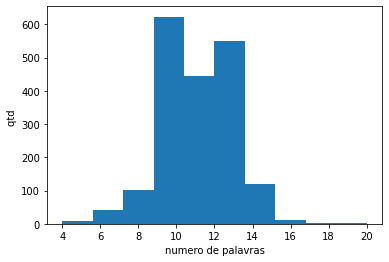

In [18]:
turismo.title_n_words.hist();
plt.xlabel('numero de palavras')
plt.ylabel('qtd ')
plt.grid(b=None)
plt.show()

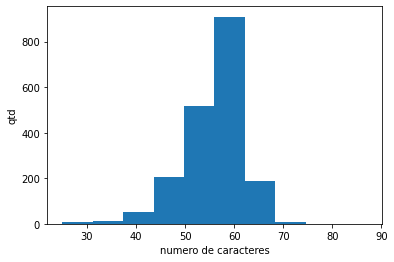

In [21]:
turismo.title_n_chars.hist();
plt.xlabel('numero de caracteres')
plt.ylabel('qtd')
plt.grid(b=None)
plt.show()

In [25]:
# limpeza dos dados

nlp_pt = spacy.load('pt_core_news_sm')

In [26]:
rev = turismo.iloc[0]['title']

In [27]:
rev

'Latam inaugura voo direto de 15 horas entre Chile e Austrália'

In [38]:
rev = limpa_texto(rev)

In [39]:
rev

'latam inaugura voo direto de 15 hora entre chile e au trália'

In [41]:
rev2 = turismo.iloc[5]['title']

In [42]:
rev2

"'Viagem ao Japão é aula de cultura e tradição', diz ator Jayme Matarazzo"

In [43]:
limpa_texto(rev2)

'viagem ao japão é aula de cultura e tradição diz ator jayme matarazzo'

In [44]:
rev = nlp_pt(rev)

In [50]:
def exibe_token(texto):
  col_names = ['ALPHA', 'PUNCT', 'LIKE NUM', 'POS']
  formatted_text = '{:>16}' * (len(col_names)+ 1)
  print('\n', formatted_text.format('INPUT WORD', *col_names), '\n', '='*130)


  for token in texto:
    output = [token.text, token.is_alpha, token.is_punct, token.like_num, token.pos_]
    print(formatted_text.format(*output))

In [51]:
exibe_token(rev)


       INPUT WORD           ALPHA           PUNCT        LIKE NUM             POS 
           latam               1               0               0            VERB
        inaugura               1               0               0            VERB
             voo               1               0               0            VERB
          direto               1               0               0             ADV
              de               1               0               0             ADP
              15               0               0               1             NUM
            hora               1               0               0            NOUN
           entre               1               0               0             ADP
           chile               1               0               0           PROPN
               e               1               0               0           CCONJ
              au               1               0               0           PROPN
          trália         

In [52]:
from spacy import displacy

displacy.render (rev, style='dep', jupyter=True)

In [53]:
rev2 = nlp_pt(rev2)

In [54]:
exibe_token(rev2)


       INPUT WORD           ALPHA           PUNCT        LIKE NUM             POS 
               '               0               1               0           PUNCT
          Viagem               1               0               0            NOUN
               a               1               0               0             ADP
               o               1               0               0             DET
           Japão               1               0               0           PROPN
               é               1               0               0            VERB
            aula               1               0               0            NOUN
              de               1               0               0             ADP
         cultura               1               0               0            NOUN
               e               1               0               0           CCONJ
        tradição               1               0               0            NOUN
               '         

In [55]:
turismo['title_clean'] = turismo['title'].apply(lambda x : limpa_texto(x))


In [59]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars,title_clean,title_clean_no_stop
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51,latam inaugura voo direto de 15 horas entre ch...,latam inaugura voo direto 15 horas chile e aus...
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54,turismo de las vegas deve se recuperar em mese...,turismo las vegas recuperar analistas
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58,brasileiro cria app para economizar no passeio...,brasileiro cria app economizar passeio gôndola...
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38,airbnb passa a fazer reserva de restaurantes,airbnb passa a reserva restaurantes
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62,museus lembram quatro décadas de opressão sovi...,museus lembram décadas opressão soviética países


In [60]:
turismo['title_clean_no_stop'] = turismo['title_clean'].apply(lambda x: remove_stop(x) )

In [61]:
turismo.iloc[0]['title_clean']

'latam inaugura voo direto de 15 horas entre chile e austrália'

In [63]:
turismo.iloc[0]['title_clean_no_stop']

'latam inaugura voo direto 15 horas chile e austrália'

In [64]:
turismo['title_lemmas'] = turismo['title_clean_no_stop'].apply(lambda x : limpa_texto2(x))

In [65]:
turismo.iloc[0]['title_lemmas']

'latir inaugurar voar direto 15 horar chile e austrália'

In [66]:
turismo.iloc[5]['title_lemmas']

'viagem o o japão aula cultura e tradição ator jayme matarazzo'

In [68]:
titulos = " ".join(turismo['title_lemmas'])

In [69]:
token = word_tokenize(titulos)

In [71]:
bigram = ngrams(token, 2)

In [72]:
print(Counter(bigram).most_common(10))

[(('o', 'o'), 91), (('fotógrafo', 'registrar'), 39), (('atrair', 'turista'), 25), (('fotógrafo', 'clicar'), 23), (('álbum', 'viagem'), 22), (('companhia', 'aéreo'), 20), (('turista', 'o'), 20), (('o', 'turismo'), 20), (('viagem', 'o'), 18), (('e', 'o'), 18)]


In [73]:
trigram = ngrams(token, 3)

In [74]:
print(Counter(trigram).most_common(10))

[(('voltar', 'o', 'o'), 8), (('atrair', 'turista', 'o'), 7), (('fotógrafo', 'registrar', 'o'), 7), (('museu', 'dedicar', 'o'), 6), (('o', 'o', 'redor'), 6), (('o', 'o', 'mundo'), 6), (('o', 'o', 'público'), 6), (('viagem', 'o', 'o'), 5), (('fotógrafo', 'registrar', 'paisagem'), 5), (('o', 'redor', 'mundo'), 5)]


In [75]:
vectorizer = CountVectorizer(min_df=10, max_df=0.9, stop_words=STOP_WORDS, lowercase=True)

In [77]:
data_vectorized = vectorizer.fit_transform(turismo['title_lemmas'])

In [79]:
NUM_TOPICS = 2
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=30, learning_method='online', verbose=True)

In [80]:
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


In [81]:
import pyLDAvis.sklearn

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [82]:
pyLDAvis.enable_notebook()

In [83]:
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')

In [84]:
dash 

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
1     -60.312317  141.369629       1        1  52.982967
0      60.312561 -141.369141       2        1  47.017033, topic_info=          Term        Freq       Total Category  logprob  loglift
103  fotógrafo  103.000000  103.000000  Default  30.0000  30.0000
213    turismo  111.000000  111.000000  Default  29.0000  29.0000
114      hotel  103.000000  103.000000  Default  28.0000  28.0000
154     parque   65.000000   65.000000  Default  27.0000  27.0000
138      mundo   80.000000   80.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
75         dia   23.195936   24.043268   Topic2  -4.7383   0.7188
214    turista  149.744709  191.472002   Topic2  -2.8733   0.5089
102       foto   30.339654   33.005287   Topic2  -4.4698   0.6704
221     viagem   74.062945  115.591590   Topic2  -3.5774   0.3095
50      cidade   38.395100   79.800618   Topic2  -4.2343   0.0231

[110 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
6         1  0.981355      abrir
6         2  0.032712      abrir
7         1  0.958605  aeroporto
7         2  0.045648  aeroporto
9         1  0.961954     airbnb
...     ...       ...        ...
233       1  0.972630     voltar
233       2  0.040526     voltar
238       1  0.036646       água
238       2  0.989447       água
239       2  0.994672      álbum

[151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])